# **Supermart Grocery Sales Analysis**

### **Objective**
**The objective of this project is to analyze grocery retail sales data to understand sales performance, profitability, and 
customer demand across categories, regions, and time.The analysis aims to identify revenue drivers, loss-making segments, 
seasonal trends, and the impact of discounts to support better pricing, inventory, and business decision-making**

### **Dataset Overview**
**The dataset contains transactional grocery sales data including order details, customer information, product category and 
sub-category, sales value, discount, profit, and regional information. The data represents real-world retail operations across 
multiple regions and cities.**

**Step 1: Importing Required Libraries**

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


**Step 2: Settings to Save Files**

In [2]:
DATA_PATH = r"C:\Users\Prath\Downloads\Supermart Grocery Sales - Retail Analytics Dataset.csv"

OUT_DIR = "outputs_supermart"
TABLES_DIR = os.path.join(OUT_DIR, "tables")
CHARTS_DIR = os.path.join(OUT_DIR, "charts")

os.makedirs(TABLES_DIR, exist_ok=True)
os.makedirs(CHARTS_DIR, exist_ok=True)

print("Tables:", os.path.abspath(TABLES_DIR))
print("Charts:", os.path.abspath(CHARTS_DIR))

Tables: C:\Users\Prath\outputs_supermart\tables
Charts: C:\Users\Prath\outputs_supermart\charts


**Step 3: Using Helper Function**

In [3]:
def safe_filename(name: str) -> str:
    name = str(name).strip().lower()
    name = re.sub(r"[^a-z0-9]+", "_", name)
    return name.strip("_") or "file"

def export_csv(df: pd.DataFrame, filename: str) -> str:
    path = os.path.join(TABLES_DIR, f"{safe_filename(filename)}.csv")
    df.to_csv(path, index=False, encoding="utf-8-sig")
    return os.path.abspath(path)

def save_and_show(filename: str, dpi: int = 180) -> str:
    path = os.path.join(CHARTS_DIR, filename)
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close()
    print("Saved:", os.path.abspath(path))
    return os.path.abspath(path)

**Step 4: Load Data**

In [4]:
df_raw = pd.read_csv(DATA_PATH)
df_raw.columns = [c.strip() for c in df_raw.columns]

print("✅ Rows:", len(df_raw))
print("✅ Columns:", df_raw.columns.tolist())
display(df_raw.head())


✅ Rows: 9994
✅ Columns: ['Order ID', 'Customer Name', 'Category', 'Sub Category', 'City', 'Order Date', 'Region', 'Sales', 'Discount', 'Profit', 'State']


,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu


**Step 5:Basic Cleaning + Data Quality**

In [6]:
df = df_raw.copy()

# Date
df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce", dayfirst=True)

# Numeric columns (best effort)
for col in ["Sales", "Profit", "Discount"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Remove missing essentials + duplicates
dup = int(df.duplicated().sum())
df = df.drop_duplicates().copy()
df = df[df["Order Date"].notna() & df["Sales"].notna() & (df["Sales"] > 0)].copy()

# Date features
df["Order_Year"] = df["Order Date"].dt.year
df["Order_Month"] = df["Order Date"].dt.to_period("M").astype(str)
df["Order_Quarter"] = df["Order Date"].dt.to_period("Q").astype(str)

# Profit margin
df["Profit_Margin_%"] = np.where(df["Sales"] != 0, (df["Profit"] / df["Sales"]) * 100, np.nan)

print(f" Duplicates removed: {dup}")
print(" Final rows:", len(df))

export_csv(df, "cleaned_supermart_data")


 Duplicates removed: 0
 Final rows: 4042


'C:\\Users\\Prath\\outputs_supermart\\tables\\cleaned_supermart_data.csv'

**Step 6: KPIs Summary**

In [7]:
kpi = pd.DataFrame([{
    "Total_Sales": df["Sales"].sum(),
    "Total_Profit": df["Profit"].sum(),
    "Overall_Profit_Margin_%": (df["Profit"].sum() / df["Sales"].sum()) * 100,
    "Total_Orders": df["Order ID"].nunique(),
    "Total_Customers": df["Customer Name"].nunique(),
    "Avg_Order_Value": df["Sales"].sum() / df["Order ID"].nunique(),
    "Avg_Discount": df["Discount"].mean()
}])

export_csv(kpi, "kpi_summary")
display(kpi)


,Total_Sales,Total_Profit,Overall_Profit_Margin_%,Total_Orders,Total_Customers,Avg_Order_Value,Avg_Discount
0,6053500,1503059.03,24.829587,4042,50,1497.649678,0.226455


## **Exploratory Data Analysis (EDA)**

**Step 7: Charts**

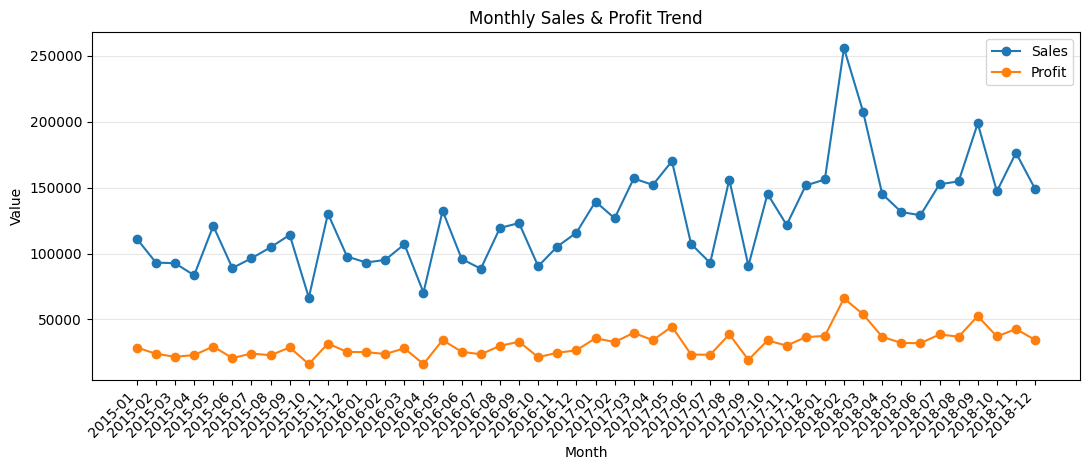

Saved: C:\Users\Prath\outputs_supermart\charts\monthly_sales_profit_trend.png


'C:\\Users\\Prath\\outputs_supermart\\charts\\monthly_sales_profit_trend.png'

In [8]:
# A) Monthly Sales Trend
monthly = df.groupby("Order_Month", as_index=False).agg(Sales=("Sales", "sum"), Profit=("Profit", "sum"))
monthly["m_dt"] = pd.to_datetime(monthly["Order_Month"], errors="coerce")
monthly = monthly.sort_values("m_dt").drop(columns=["m_dt"])
export_csv(monthly, "monthly_trend")

plt.figure(figsize=(11, 4.8))
plt.plot(monthly["Order_Month"], monthly["Sales"], marker="o", label="Sales")
plt.plot(monthly["Order_Month"], monthly["Profit"], marker="o", label="Profit")
plt.title("Monthly Sales & Profit Trend")
plt.xlabel("Month")
plt.ylabel("Value")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
save_and_show("monthly_sales_profit_trend.png")

**Chart Purpose:
This chart shows how sales and profit change over time and helps identify seasonal patterns, growth phases, and periods of declining performance.**

**Business Use:
Helps management plan inventory, promotions, and staffing during high-demand months and address low-performance periods early.**

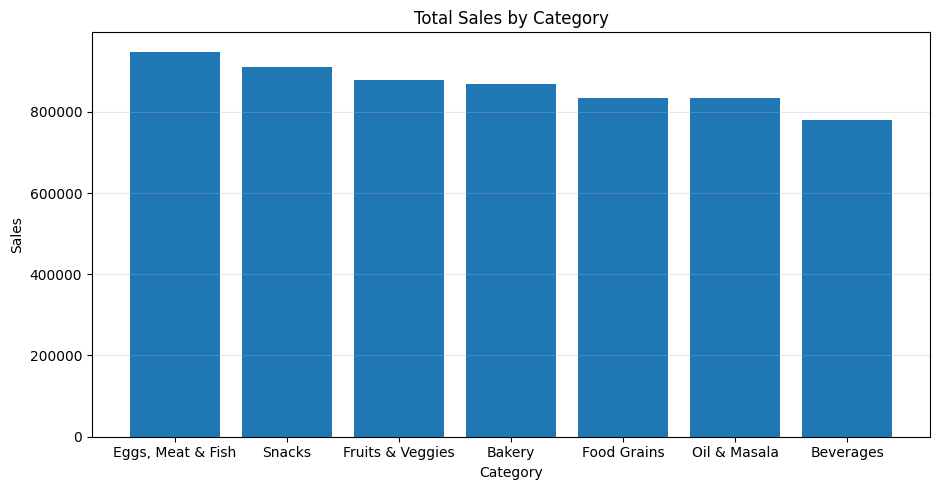

Saved: C:\Users\Prath\outputs_supermart\charts\sales_by_category.png


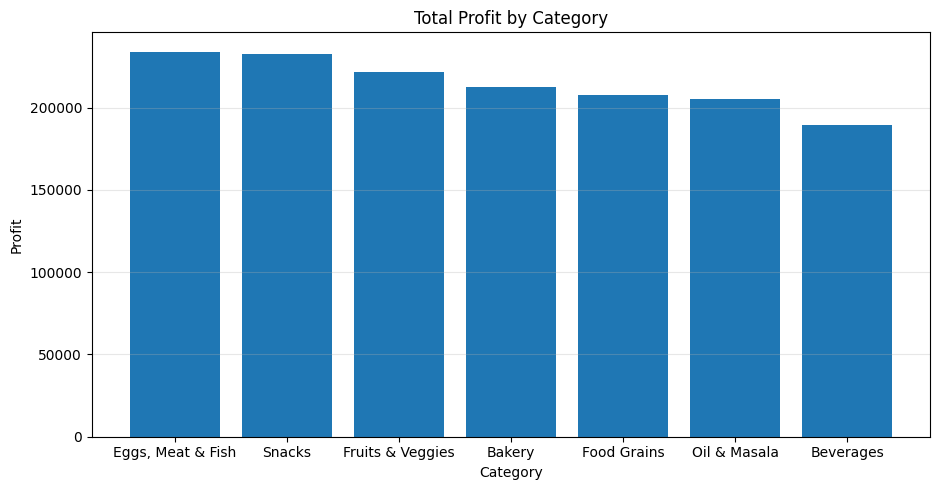

Saved: C:\Users\Prath\outputs_supermart\charts\profit_by_category.png


'C:\\Users\\Prath\\outputs_supermart\\charts\\profit_by_category.png'

In [9]:
# B) Sales by Category (keep names, don't encode)
cat_perf = df.groupby("Category", as_index=False).agg(
    Sales=("Sales", "sum"),
    Profit=("Profit", "sum"),
    Profit_Margin=("Profit_Margin_%", "mean"),
    Avg_Discount=("Discount", "mean")
).sort_values("Sales", ascending=False)

export_csv(cat_perf, "category_performance")

plt.figure(figsize=(9.5, 5))
plt.bar(cat_perf["Category"], cat_perf["Sales"])
plt.title("Total Sales by Category")
plt.xlabel("Category")
plt.ylabel("Sales")
plt.grid(True, axis="y", alpha=0.3)
save_and_show("sales_by_category.png")

plt.figure(figsize=(9.5, 5))
plt.bar(cat_perf["Category"], cat_perf["Profit"])
plt.title("Total Profit by Category")
plt.xlabel("Category")
plt.ylabel("Profit")
plt.grid(True, axis="y", alpha=0.3)
save_and_show("profit_by_category.png")


#### for Sales by Category
**Chart Purpose:
This chart compares total sales across different product categories to identify which categories contribute most to revenue.**

**Business Use:
Supports inventory prioritization and category-level marketing strategies by focusing on high-revenue categories.**

#### for Profit by Category
**Chart Purpose:
This chart highlights profit contribution by category, helping distinguish between high-revenue and high-profit categories.**

**Business Use:
Enables decision-makers to focus on profitable categories rather than only high-sales categories.**

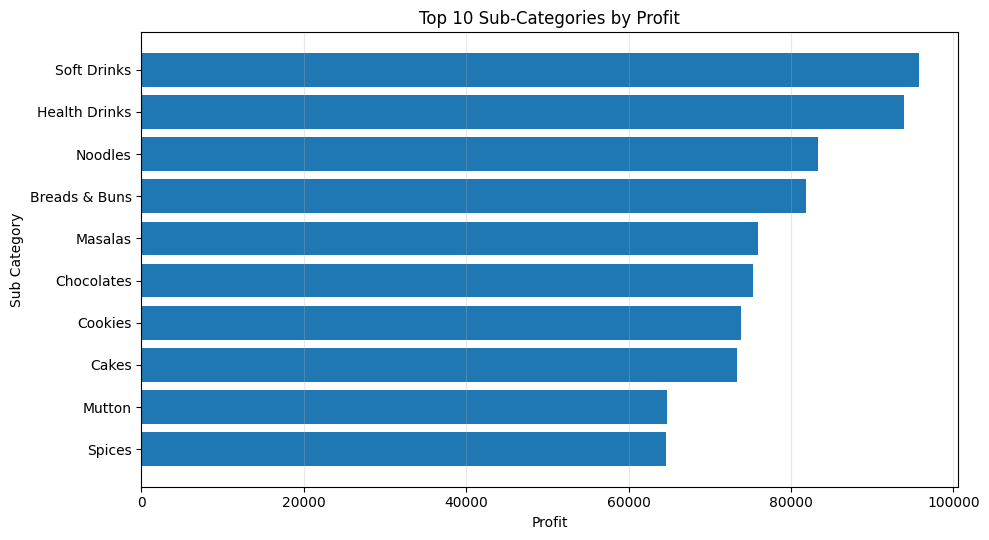

Saved: C:\Users\Prath\outputs_supermart\charts\top10_subcategory_profit.png


'C:\\Users\\Prath\\outputs_supermart\\charts\\top10_subcategory_profit.png'

In [10]:
# C) Top 10 Sub Categories by Profit
sub_profit = (df.groupby("Sub Category", as_index=False)
              .agg(Profit=("Profit", "sum"), Sales=("Sales", "sum"))
              .sort_values("Profit", ascending=False)
              .head(10))

export_csv(sub_profit, "top10_subcategory_profit")

plt.figure(figsize=(10, 5.5))
plt.barh(sub_profit["Sub Category"][::-1], sub_profit["Profit"][::-1])
plt.title("Top 10 Sub-Categories by Profit")
plt.xlabel("Profit")
plt.ylabel("Sub Category")
plt.grid(True, axis="x", alpha=0.3)
save_and_show("top10_subcategory_profit.png")


**Chart Purpose:
This chart identifies the most profitable sub-categories within the store’s product mix.**

**Business Use:
Useful for optimizing product assortment, shelf space allocation, and promotional focus on top-performing products.**

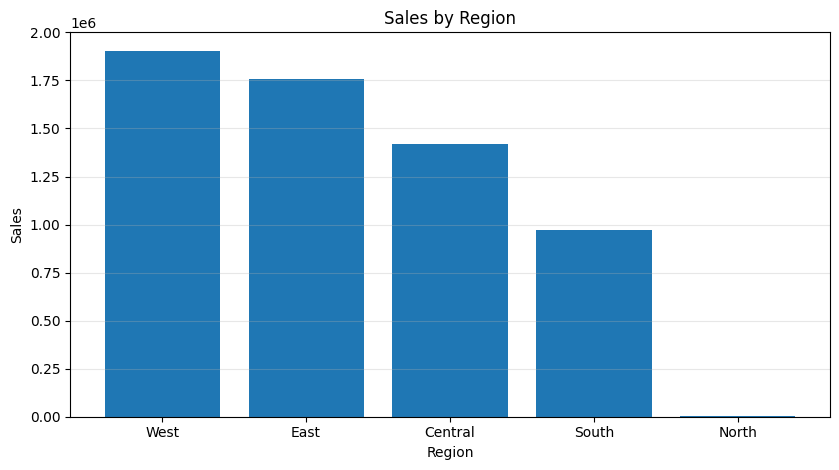

Saved: C:\Users\Prath\outputs_supermart\charts\sales_by_region.png


'C:\\Users\\Prath\\outputs_supermart\\charts\\sales_by_region.png'

In [11]:
# D) Region Performance
region_perf = df.groupby("Region", as_index=False).agg(Sales=("Sales", "sum"), Profit=("Profit", "sum"))
region_perf = region_perf.sort_values("Sales", ascending=False)
export_csv(region_perf, "region_performance")

plt.figure(figsize=(8.5, 4.8))
plt.bar(region_perf["Region"], region_perf["Sales"])
plt.title("Sales by Region")
plt.xlabel("Region")
plt.ylabel("Sales")
plt.grid(True, axis="y", alpha=0.3)
save_and_show("sales_by_region.png")

**Chart Purpose:
This chart shows regional differences in sales performance.**

**Business Use:
Helps identify strong and weak regions, supporting region-specific sales strategies and operational planning.**

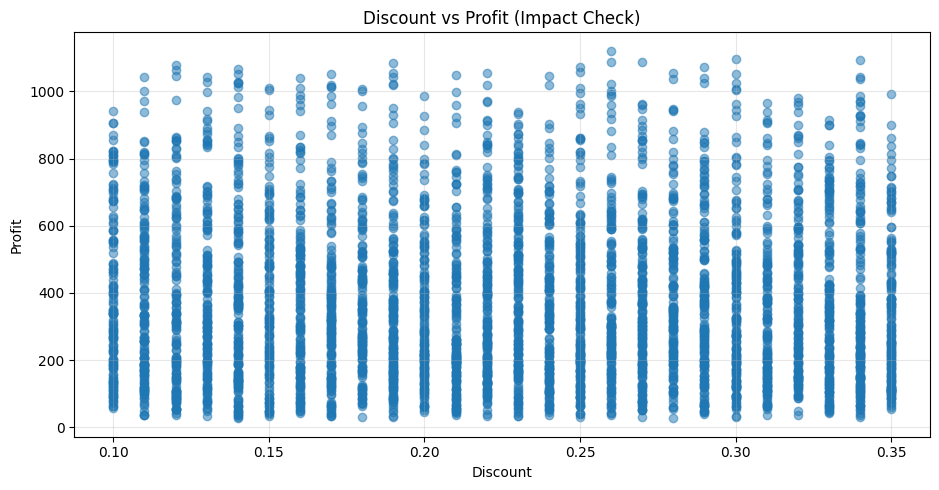

Saved: C:\Users\Prath\outputs_supermart\charts\discount_vs_profit.png


'C:\\Users\\Prath\\outputs_supermart\\charts\\discount_vs_profit.png'

In [12]:
# E) Discount vs Profit
plt.figure(figsize=(9.5, 5))
plt.scatter(df["Discount"], df["Profit"], alpha=0.5)
plt.title("Discount vs Profit (Impact Check)")
plt.xlabel("Discount")
plt.ylabel("Profit")
plt.grid(True, alpha=0.3)
save_and_show("discount_vs_profit.png")

**Chart Purpose:
This chart analyzes the relationship between discounts and profit to understand whether discounting strategies are effective or harmful.**

**Business Use:
Supports optimization of discount policies to balance customer attraction and profitability.**

In [13]:
# F) Loss-making subcategories (extra impressive)
loss_subcat = (df.groupby(["Category", "Sub Category"], as_index=False)
               .agg(Sales=("Sales", "sum"), Profit=("Profit", "sum"), Avg_Discount=("Discount", "mean"))
               .sort_values("Profit"))

loss_only = loss_subcat[loss_subcat["Profit"] < 0].head(15)
export_csv(loss_subcat, "profit_by_category_subcategory_all")
export_csv(loss_only, "top_loss_making_subcategories")

display(loss_only)


,Category,Sub Category,Sales,Profit,Avg_Discount


## **Business Use**
**The insights from this analysis can help:**

**1.Optimize pricing and discount strategies**

**2.Improve inventory and product assortment decisions**

**3.Focus marketing efforts on high-profit categories**

**4.Identify underperforming regions and products**

**5.Support data-driven retail planning and profitability improvement**

## **Conclusion**
**This project analyzed Supermart grocery retail sales data to understand business performance across time, categories, regions, and products. 
After cleaning and preparing the dataset, key KPIs and visualizations were created to highlight trends in sales and profit.**
**The analysis reveals that sales and profitability vary by category and sub-category, proving that high sales does not always mean high profit. 
Regional performance identifies strong and weak areas, while discount vs profit analysis highlights how discounting can impact profitability.
Additionally, loss-making sub-categories were identified for corrective action such as revising pricing, limiting discounts, or optimizing inventory.**
**As an extra step, a simple sales prediction model was built using one-hot encoding and linear regression to demonstrate applied analytics skills.
Overall, this project demonstrates a complete data analyst workflow: data cleaning, KPI reporting, EDA, insights, and actionable recommendations.**
